In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import cumulative_trapezoid

$$H=-\frac{1}{2}\frac{d^2}{dr^2}+V_Z(r)+\frac{\ell (\ell +1)}{2r^2}$$
$$-\frac{1}{2}\frac{u_{i-1}-2 u_{i}+u_{i+1}}{\Delta r^2}+V_Z(i\Delta r)u_i+\frac{\ell (\ell +1)}{2(i\Delta r)^2}u_i=Eu_i$$
$$\sum_{j=1}^{N}H_{ij}u_{j}=Eu_i$$
$$$$

In [9]:
def radial_eq_solver(n : int, l : int, Z : int, phi : np.ndarray, r : np.ndarray) -> tuple:
    """
    Solves the radial equation for a given potential.
    Parameters:
    n (int): Principal quantum number.
    l (int): Azimuthal quantum number.
    Z (int): Atomic number.
    phi (np.ndarray): Potential energy produced by other electrons.
    r (np.ndarray): Radial grid points.
    Returns:
    tuple: A tuple containing:
        - R (np.ndarray): Radial wave function.
        - E_values[n-1] (float): Energy eigenvalue corresponding to the nth state.
    """
    dr = r[1] - r[0]
    N = len(r)

    diag = 1 / (dr**2) - Z / r + l * (l + 1) / (2 * r**2) + phi
    off_diag = -1 / (2*dr**2) * np.ones(N - 1)

    E_values, U_vectors = eigh_tridiagonal(diag, off_diag)

    u = U_vectors[:, n-1]
    R = u / r
    R /= np.linalg.norm(R) * np.sqrt(dr)
    
    return R, E_values[n-1]

# TODO: Implement the function solve_poisson eith finite differnece method
def solve_poisson(r, rho):
    """
    Solve Poisson's equation for a given radial charge density rho(r) in atomic units.

    Parameters:
    r : numpy array
        Radial grid points (must start from a small positive value to avoid singularity).
    rho : numpy array
        Charge density at each radial point.

    Returns:
    phi : numpy array
        Electrostatic potential at each radial point.
    """
    r = np.asarray(r)
    rho = np.asarray(rho)

    # Q(r) = ∫ 4πρ(r') r'^2 dr'
    Q = 4 * np.pi * cumulative_trapezoid(rho * r**2, r, initial=0)

    # E(r) = Q(r) / r^2
    E = np.zeros_like(r)
    mask = r > 0  # Avoid division by zero at r = 0
    E[mask] = Q[mask] / r[mask]**2

    # phi(r) = -∫_r^(r_max) E(r') dr'
    phi_reversed = cumulative_trapezoid(E[::-1], r[::-1], initial=0)
    phi = -phi_reversed[::-1]
    
    return phi

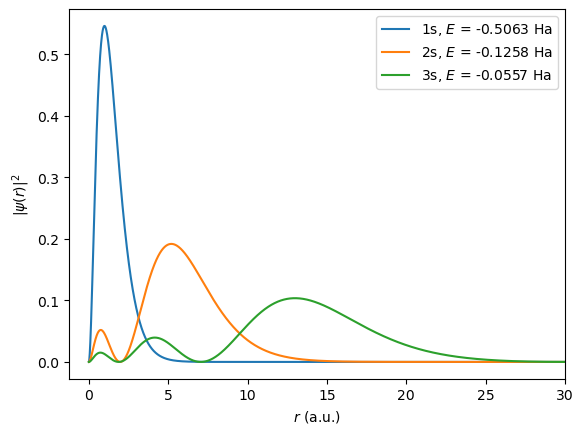

In [13]:
r = np.linspace(0.003, 30, 5000)
phi = np.zeros_like(r)
R1s, E1s = radial_eq_solver(1, 0, 1, phi, r)
R2s, E2s = radial_eq_solver(2, 0, 1, phi, r)
R3s, E3s = radial_eq_solver(3, 0, 1, phi, r)

psi1 = r**2*R1s**2 / np.trapz(r**2*R1s**2, r)
psi2 = r**2*R2s**2 / np.trapz(r**2*R2s**2, r)
psi3 = r**2*R3s**2 / np.trapz(r**2*R3s**2, r)

plt.plot(r, psi1, label="1s, $E$ = {:.4f} Ha".format(E1s))
plt.plot(r, psi2, label="2s, $E$ = {:.4f} Ha".format(E2s))
plt.plot(r, psi3, label="3s, $E$ = {:.4f} Ha".format(E3s))
plt.legend()
plt.xlabel("$r$ (a.u.)")
plt.ylabel("$|\\psi(r)|^2$")
plt.xlim(-1.25, 30)
plt.show()

In [14]:
# Example of self-consistent field iteration
# TODO: implement better radial_eq_solver and solve_poisson

r = np.linspace(0.002, 20, 3000)
rho = np.zeros_like(r)
phi = np.zeros_like(r)

for i in range(10):
    R1s, E1 = radial_eq_solver(1, 0, 2, phi, r)
    R2s, E2 = radial_eq_solver(2, 0, 2, phi, r)
    print(f"Iteration {i}: E_tot = {(E1+E2)*27.2114:.4} eV (E1s = {E1*27.2114:.4} eV, E2s = {E2*27.2114:.4} eV)")
    rho = -2*R1s**2*r**2-R2s**2*r**2
    phi = solve_poisson(r, rho/(4*np.pi))

Iteration 0: E_tot = -70.72 eV (E1s = -56.82 eV, E2s = -13.9 eV)
Iteration 1: E_tot = -154.1 eV (E1s = -101.0 eV, E2s = -53.11 eV)
Iteration 2: E_tot = -113.8 eV (E1s = -80.67 eV, E2s = -33.12 eV)
Iteration 3: E_tot = -117.2 eV (E1s = -82.41 eV, E2s = -34.82 eV)
Iteration 4: E_tot = -116.8 eV (E1s = -82.19 eV, E2s = -34.61 eV)
Iteration 5: E_tot = -116.8 eV (E1s = -82.22 eV, E2s = -34.63 eV)
Iteration 6: E_tot = -116.8 eV (E1s = -82.21 eV, E2s = -34.63 eV)
Iteration 7: E_tot = -116.8 eV (E1s = -82.21 eV, E2s = -34.63 eV)
Iteration 8: E_tot = -116.8 eV (E1s = -82.21 eV, E2s = -34.63 eV)
Iteration 9: E_tot = -116.8 eV (E1s = -82.21 eV, E2s = -34.63 eV)
